# Imports and General Settings

In [ ]:
import tensorflow as tf
import tensorflow.contrib as tf_contrib

import os
import pathlib

import numpy as np

import io

import random

import pylab
import tfplot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tfx
import tensorflow_transform as tft

from cleverhans.loss import SNNLCrossEntropy

# import self utility functions
import model_arch_utility as model_arch
import log_utility as log_util
import data_augmentation_utility as da_util
import load_data_utility as load_data_util

# tensorflow specific settings
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

# which GPU to be used (0 is RTX, 1 or 2 are either of the Titan Xps)
gpu = "/GPU:0"

AUTOTUNE = tf.contrib.data.AUTOTUNE

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
session_config.allow_soft_placement = True

# session_config.log_device_placement = True
tf.keras.backend.set_session(tf.Session(config=session_config))

# make sure tensorflow-gpu is being used
print(tf.test.gpu_device_name())

# Data Augmentation

In [2]:
# data augmentation methods in data_augmentation_utility.py

# choose augmentation in load_data_utility.py

# ConvNet

## ConvNet Architecture

In [52]:
num_classes = 2

# ResNet-10 architecture
def convnet_network(x, conv_kernels=[10,7,3,3], num_channels=8, n_classes=num_classes, reuse = False, is_training = True):
    with tf.variable_scope('ConvNet', reuse = reuse), tf.device(gpu):
        
        x = tf.reshape(x, shape=[-1, 512, 512, 1])
        # channels
        
        filtered_images = []
        
        filtered_images.append(tf.identity(x))
        
        counter = 0
        for kernel in conv_kernels:
        
            x = model_arch.conv(x, num_channels, kernel=kernel, stride=2, padding='SAME', scope='conv_' + str(counter))
            x = model_arch.relu(x)
            
#             x = model_arch.max_pooling(x)
            
            x = model_arch.batch_norm(x, is_training, scope='batch_norm_' + str(counter))
            
            filtered_images.append(tf.identity(x))
            
            counter = counter + 1
            num_channels = num_channels * 2
 
        x_pre_flatten = tf.identity(x)
        
        x = model_arch.fully_connected(x, num_classes)
        
        return x, x_pre_flatten, filtered_images

    
def convnet_model_fn(features, labels, mode, conv_kernels=[10,7,3,3], num_channels=8, snnl_weight=0.05,
                      log=True):
    with tf.device(gpu):

        print("in gpu part")
        logits_train, activ_maps_train, filtered_images = convnet_network(features,
                                                                          conv_kernels=conv_kernels,
                                                                          num_channels=num_channels,
                                                                          n_classes=num_classes,
                                                                          reuse=False,
                                                                          is_training=True)
        
        logits_test, activ_maps_test, _ = convnet_network(features,
                                                          conv_kernels=conv_kernels,
                                                          num_channels=num_channels,
                                                          n_classes=num_classes,
                                                          reuse=False,
                                                          is_training=True)


        pred_classes = tf.arg_max(logits_test, dimension=1)

        # PREDICT MODE
        if mode == tf.estimator.ModeKeys.PREDICT:

            
            prediction_dict = {
                'class_ids': pred_classes[:, tf.newaxis],
                'probabilities': tf.nn.softmax(logits_test),
                'logits': logits_test,
            }
            
            return tf.estimator.EstimatorSpec(mode=mode, predictions=prediction_dict)


        loss_op = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
        # last layer SNNL
#         loss_op = (1.0 - snnl_weight) * loss_op + snnl_weight * SNNLCrossEntropy.optimized_temp_SNNL(
#             model_arch.flatten(activ_maps_train), labels, 20.0, False)

        # first layer SNNL
        loss_op = (1.0 - snnl_weight) * loss_op + snnl_weight * SNNLCrossEntropy.optimized_temp_SNNL(
            model_arch.flatten(filtered_images[0]), labels, 20.0, False)
      
    
        acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
        
        roc_op = tf.metrics.auc(labels, pred_classes, curve='ROC', summation_method='careful_interpolation')
        precision_recall_op = tf.metrics.auc(labels, pred_classes, curve='PR', summation_method='careful_interpolation')
        
        if (not log):
            tf.summary.scalar("loss", loss_op)
            tf.summary.scalar("accuracy", acc_op[1])
            tf.summary.scalar("roc", roc_op[1])
            tf.summary.scalar("precision-recall", precision_recall_op[1])
            
        if mode == tf.estimator.ModeKeys.TRAIN:
                

            # the different ops for training, evaluating, ...
            estim_specs = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=pred_classes,
                loss=loss_op,
                train_op=train_op,
                eval_metric_ops={'accuracy': acc_op}
            )

            return estim_specs
    
#     for var in tf.trainable_variables():
#         print(var.name)

        if (log):

#             conv0_weights = [v for v in tf.global_variables() if v.name == "Resnet-10/conv_0/conv2d/kernel:0"][0]

#             plot_op_expanded = tf.expand_dims(log_util.plot_conv_weights(conv0_weights), 0)
#             tf.summary.image("conv_0_weight_plots", plot_op_expanded)


            with tf.name_scope("activation_maps"):

                counter = 0

                plot_ops = []

                for filtered_im in filtered_images:

                    name = "after_conv_" + str(counter)
                    if counter == 0:
                        name = "original_image:"
                    
                    activation_map = tf.slice(filtered_im,[0, 0, 0, 0],[1, -1, -1, -1])
                    activation_op = tf.expand_dims(log_util.plot_conv_output(activation_map, name), 0)

                    plot_ops.append(activation_op)

                    counter = counter + 1

                final_log_op = tf.concat(plot_ops, 2)

                tf.summary.image("image_display", final_log_op)
        
        eval_summary_hook = tf.train.SummarySaverHook(
            save_steps=1,
            output_dir=model_path + "/eval_images",
            summary_op=tf.summary.merge_all())
        # Add it to the evaluation_hook list
        evaluation_hooks = []
        evaluation_hooks.append(eval_summary_hook)

        # the different ops for training, evaluating, ...
        estim_specs = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss_op,
            train_op=train_op,
            eval_metric_ops={'accuracy': acc_op},
            evaluation_hooks=evaluation_hooks
        )

        return estim_specs

# Running Results

## Experimentation

In [28]:
tf.logging.set_verbosity(tf.logging.INFO)
tf.summary.FileWriterCache.clear()
b_size = 32

learning_rate = 0.001

random_seed = 777

random.seed(a=random_seed)

num_steps = 10000

# convnet_checkpoint_path_base = "/data/jma/model/dataset_experiments/no_data_aug_no_norm/"

convnet_checkpoint_path_base = "/data/jma/model/binary_cnn_V2/roc_tests/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

# kernel_sizes = [[10, 7, 3]] v1
# kernel_sizes = [[10, 7, 3, 3]] v2
kernel_sizes = [[10,7,3,3]]
filter_sizes = [16]
snnl_weights = [0.0]

# data_root = "./data/data_relabeled_png_synthetic/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)


dataset_root = "./data/generated_splits/2class/"

# sets = ["ali_relabeled_original", "peter_relabeled_original", "ali_relabeled_undersampled", "peter_relabeled_undersampled"]
sets = ["ali_relabeled_original", "ali_relabeled_undersampled"]


for dt_set in sets:
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:

                train_root = dataset_root + dt_set + "/train/"
                eval_root = dataset_root + dt_set + "/eval/"
               
                train_paths = load_data_util.load_image_paths(train_root)
                random.shuffle(train_paths)

                print(train_root)
                
                eval_paths = load_data_util.load_image_paths(eval_root)
                
                train_input_fn = lambda : load_data_util.load(train_root, train_paths, training=True, augment=False, batch_size=32, norm=False, shuffle=False)
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, norm=False, shuffle=False)


                model_path = convnet_checkpoint_path_base + dt_set + "_filter" + str(filter_size)+"_snnl" + str(snnl_weight) + "/"
                print(model_path)

                config = tf.estimator.RunConfig(
                    log_step_count_steps= 20,
                    save_summary_steps= 30,
                    save_checkpoints_secs= 30,
                    model_dir=model_path,
                    tf_random_seed=random_seed,
                    session_config=session_config)

                model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                            conv_kernels=kernel_size, 
                                                                             num_channels=filter_size,
                                                                            snnl_weight=snnl_weight,
                                                                            log=False)

                model = tf.estimator.Estimator(model_fn=model_fn, config=config)

                train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=num_steps)
                eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, throttle_secs=30)

                tf.estimator.train_and_evaluate(model, train_spec, eval_spec)

        

./data/generated_splits/2class/ali_relabeled_original/train/
/data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/', '_tf_random_seed': 777, '_save_summary_steps': 30, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 30, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 20, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6444d8ca58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:R

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-24-23:29:28
INFO:tensorflow:Saving dict for global step 687: accuracy = 0.82464457, global_step = 687, loss = 4.2413044
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 687: /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt-687
INFO:tensorflow:global_step/sec: 3.57423
INFO:tensorflow:loss = 2.451149e-06, step = 700 (5.594 sec)
INFO:tensorflow:global_step/sec: 5.81818
INFO:tensorflow:loss = 9.015133e-07, step = 720 (3.439 sec)
INFO:tensorflow:global_step/sec: 5.54145
INFO:tensorflow:loss = 3.7997856e-07, step = 740 (3.609 sec)
INFO:tensorflow:global_step/sec: 5.51348
INFO:tensorflow:loss = 1.1546272e-05, step = 760 (3.628 sec)
INFO:tensorflow:global_step/sec: 5.50131
INFO:tensorflow:loss = 7.3760316e-07, step = 780 (3.637 sec)
INFO:tensorflow:global_step/sec: 6.10434
INFO:tensorflow:loss = 3.501757e-07,

pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-24-23:31:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt-1517
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-24-23:31:59
INFO:tensorflow:Saving dict for global step 1517: accuracy = 0.82464457, global_step = 1517, loss = 4.282867
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1517: /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt-1517
INFO:tensorflow:global_step/sec: 3.29759
INFO:tensorflow:loss = 5.587915e-07, step = 1520 (6.065 sec)
INFO:tensorflow:global_step/sec: 6.98536
INFO:tensorflow:loss = 1.5347823e-06, step = 1540 (2.863 sec)
INFO:tensorflow:global_step/sec: 5.66239
IN

INFO:tensorflow:loss = 1.944568e-06, step = 2280 (3.142 sec)
INFO:tensorflow:global_step/sec: 6.34183
INFO:tensorflow:loss = 3.72529e-09, step = 2300 (3.155 sec)
INFO:tensorflow:global_step/sec: 6.74861
INFO:tensorflow:loss = 7.4505797e-09, step = 2320 (2.961 sec)
INFO:tensorflow:global_step/sec: 5.93268
INFO:tensorflow:loss = 4.0233004e-07, step = 2340 (3.372 sec)
INFO:tensorflow:Saving checkpoints for 2355 into /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-24-23:34:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt-2355
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-24-23:34:30
INFO:tensorflow

INFO:tensorflow:global_step/sec: 3.08605
INFO:tensorflow:loss = 1.3895069e-06, step = 3040 (6.481 sec)
INFO:tensorflow:global_step/sec: 8.57166
INFO:tensorflow:loss = 1.117587e-08, step = 3060 (2.334 sec)
INFO:tensorflow:global_step/sec: 6.03349
INFO:tensorflow:loss = 2.5704404e-07, step = 3080 (3.314 sec)
INFO:tensorflow:global_step/sec: 6.31462
INFO:tensorflow:loss = 3.8370356e-07, step = 3100 (3.167 sec)
INFO:tensorflow:global_step/sec: 5.85002
INFO:tensorflow:loss = 3.6880198e-07, step = 3120 (3.420 sec)
INFO:tensorflow:global_step/sec: 6.20463
INFO:tensorflow:loss = 9.2759166e-07, step = 3140 (3.223 sec)
INFO:tensorflow:global_step/sec: 6.13583
INFO:tensorflow:loss = 1.1175869e-08, step = 3160 (3.259 sec)
INFO:tensorflow:global_step/sec: 5.89309
INFO:tensorflow:loss = 2.6076992e-07, step = 3180 (3.395 sec)
INFO:tensorflow:global_step/sec: 6.55665
INFO:tensorflow:loss = 4.8428756e-08, step = 3200 (3.049 sec)
INFO:tensorflow:Saving checkpoints for 3211 into /data/jma/model/binary_cn

in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-24-23:38:58
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt-3908
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-24-23:39:00
INFO:tensorflow:Saving dict for global step 3908: accuracy = 0.82464457, global_step = 3908, loss = 4.3229737
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3908: /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt-3908
INFO:tensorflow:global_step/sec: 3.71616
INFO:tensorflow:loss = 4.0978176e-08, step = 3920 (5.381 sec)
INFO:tensorflow:global_step/sec: 6.20557
INFO:tensorflow:loss = 1.117587e-08, step = 3940 (3.223 sec)
INFO:tensorflow:global_step/sec: 6.9295
INFO:tensorflow:loss = 2.57044e-07, step = 3960 (2.

INFO:tensorflow:global_step/sec: 6.39718
INFO:tensorflow:loss = 0.0, step = 4700 (3.125 sec)
INFO:tensorflow:global_step/sec: 6.59591
INFO:tensorflow:loss = 3.3154924e-07, step = 4720 (3.032 sec)
INFO:tensorflow:global_step/sec: 6.05591
INFO:tensorflow:loss = 1.3411031e-07, step = 4740 (3.303 sec)
INFO:tensorflow:global_step/sec: 6.38813
INFO:tensorflow:loss = 7.450575e-08, step = 4760 (3.131 sec)
INFO:tensorflow:Saving checkpoints for 4778 into /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-24-23:41:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt-4778
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 20

INFO:tensorflow:global_step/sec: 3.51413
INFO:tensorflow:loss = 2.3841778e-07, step = 5460 (5.692 sec)
INFO:tensorflow:global_step/sec: 5.60448
INFO:tensorflow:loss = 1.7136304e-07, step = 5480 (3.567 sec)
INFO:tensorflow:global_step/sec: 6.47017
INFO:tensorflow:loss = 1.8998935e-07, step = 5500 (3.091 sec)
INFO:tensorflow:global_step/sec: 5.76428
INFO:tensorflow:loss = 7.4505797e-09, step = 5520 (3.473 sec)
INFO:tensorflow:global_step/sec: 6.15477
INFO:tensorflow:loss = 4.2840702e-07, step = 5540 (3.246 sec)
INFO:tensorflow:global_step/sec: 6.25571
INFO:tensorflow:loss = 2.2351738e-08, step = 5560 (3.197 sec)
INFO:tensorflow:global_step/sec: 6.45178
INFO:tensorflow:loss = 0.0, step = 5580 (3.101 sec)
INFO:tensorflow:global_step/sec: 6.23082
INFO:tensorflow:loss = 8.568158e-08, step = 5600 (3.209 sec)
INFO:tensorflow:Saving checkpoints for 5615 into /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_f

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-24-23:46:01
INFO:tensorflow:Saving dict for global step 6286: accuracy = 0.82464457, global_step = 6286, loss = 4.344506
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6286: /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt-6286
INFO:tensorflow:global_step/sec: 3.78174
INFO:tensorflow:loss = 2.2351738e-08, step = 6300 (5.289 sec)
INFO:tensorflow:global_step/sec: 6.04907
INFO:tensorflow:loss = 2.2351705e-07, step = 6320 (3.306 sec)
INFO:tensorflow:global_step/sec: 6.12228
INFO:tensorflow:loss = 3.054727e-07, step = 6340 (3.267 sec)
INFO:tensorflow:global_step/sec: 6.26103
INFO:tensorflow:loss = 1.3411034e-07, step = 6360 (3.196 sec)
INFO:tensorflow:global_step/sec: 6.35892
INFO:tensorflow:loss = 8.5681634e-08, step = 6380 (3.146 sec)
INFO:tensorflow:global_step/sec: 6.26333
INFO:tensorflow:loss = 1.49

INFO:tensorflow:loss = 0.0, step = 7120 (3.363 sec)
INFO:tensorflow:Saving checkpoints for 7141 into /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-24-23:48:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt-7141
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-24-23:48:31
INFO:tensorflow:Saving dict for global step 7141: accuracy = 0.82464457, global_step = 7141, loss = 4.351723
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7141: /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt-7141
INFO:tensorflow:global_step/sec: 3.03253
INFO:tensorflo

INFO:tensorflow:loss = 7.4505797e-09, step = 7860 (3.201 sec)
INFO:tensorflow:global_step/sec: 5.83986
INFO:tensorflow:loss = 7.078049e-08, step = 7880 (3.423 sec)
INFO:tensorflow:global_step/sec: 6.23749
INFO:tensorflow:loss = 2.2351738e-08, step = 7900 (3.206 sec)
INFO:tensorflow:global_step/sec: 6.56352
INFO:tensorflow:loss = 1.6018731e-07, step = 7920 (3.048 sec)
INFO:tensorflow:global_step/sec: 6.47365
INFO:tensorflow:loss = 3.72529e-09, step = 7940 (3.089 sec)
INFO:tensorflow:global_step/sec: 6.23778
INFO:tensorflow:loss = 7.4505797e-09, step = 7960 (3.207 sec)
INFO:tensorflow:global_step/sec: 6.14291
INFO:tensorflow:loss = 1.1548393e-07, step = 7980 (3.256 sec)
INFO:tensorflow:global_step/sec: 6.7355
INFO:tensorflow:loss = 1.4901158e-08, step = 8000 (2.969 sec)
INFO:tensorflow:Saving checkpoints for 8002 into /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Don

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-24-23:53:02
INFO:tensorflow:Saving dict for global step 8694: accuracy = 0.82464457, global_step = 8694, loss = 4.364335
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8694: /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt-8694
INFO:tensorflow:global_step/sec: 3.62193
INFO:tensorflow:loss = 7.4505797e-09, step = 8700 (5.522 sec)
INFO:tensorflow:global_step/sec: 6.8349
INFO:tensorflow:loss = 2.6077025e-08, step = 8720 (2.927 sec)
INFO:tensorflow:global_step/sec: 6.49692
INFO:tensorflow:loss = 6.70552e-08, step = 8740 (3.077 sec)
INFO:tensorflow:global_step/sec: 6.50514
INFO:tensorflow:loss = 5.2154036e-08, step = 8760 (3.076 sec)
INFO:tensorflow:global_step/sec: 6.53047
INFO:tensorflow:loss = 1.2665981e-07, step = 8780 (3.061 sec)
INFO:tensorflow:global_step/sec: 7.28825
INFO:tensorflow:loss = 3.7252

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-24-23:55:32
INFO:tensorflow:Saving dict for global step 9565: accuracy = 0.82464457, global_step = 9565, loss = 4.3702555
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9565: /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_original_filter16_snnl0.0/model.ckpt-9565
INFO:tensorflow:global_step/sec: 3.76614
INFO:tensorflow:loss = 1.117587e-08, step = 9580 (5.311 sec)
INFO:tensorflow:global_step/sec: 6.112
INFO:tensorflow:loss = 2.6077021e-08, step = 9600 (3.273 sec)
INFO:tensorflow:global_step/sec: 5.70438
INFO:tensorflow:loss = 5.960463e-08, step = 9620 (3.505 sec)
INFO:tensorflow:global_step/sec: 5.91518
INFO:tensorflow:loss = 7.4505797e-09, step = 9640 (3.382 sec)
INFO:tensorflow:global_step/sec: 5.94271
INFO:tensorflow:loss = 1.8626448e-08, step = 9660 (3.366 sec)
INFO:tensorflow:global_step/sec: 5.94382
INFO:tensorflow:loss = 4.4703

in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-24-23:57:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt-186
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-24-23:57:27
INFO:tensorflow:Saving dict for global step 186: accuracy = 0.74615383, global_step = 186, loss = 3.677657
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 186: /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt-186
INFO:tensorflow:global_step/sec: 3.52564
INFO:tensorflow:loss = 0.0036942973, step = 200 (5.671 sec)
INFO:tensorflow:global_step/sec: 6.63489
INFO:tensorflow:loss = 2.1863692e-05, step = 220 (3.020 sec)
INFO:tensorflow:global_step/sec: 6.24547
INFO:tensorflow:loss = 1.19872375e-05, step = 240 

INFO:tensorflow:global_step/sec: 6.69613
INFO:tensorflow:loss = 9.61121e-07, step = 980 (2.987 sec)
INFO:tensorflow:global_step/sec: 6.44455
INFO:tensorflow:loss = 1.7881342e-07, step = 1000 (3.102 sec)
INFO:tensorflow:global_step/sec: 6.75747
INFO:tensorflow:loss = 7.823065e-07, step = 1020 (2.961 sec)
INFO:tensorflow:global_step/sec: 6.01367
INFO:tensorflow:loss = 4.470347e-08, step = 1040 (3.324 sec)
INFO:tensorflow:global_step/sec: 6.37617
INFO:tensorflow:loss = 1.4901154e-07, step = 1060 (3.137 sec)
INFO:tensorflow:Saving checkpoints for 1066 into /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-24-23:59:56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt-1066
INFO:te

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-25-00:01:58
INFO:tensorflow:Saving dict for global step 1789: accuracy = 0.77692306, global_step = 1789, loss = 3.4025931
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1789: /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt-1789
INFO:tensorflow:global_step/sec: 3.98118
INFO:tensorflow:loss = 1.1436568e-06, step = 1800 (5.025 sec)
INFO:tensorflow:global_step/sec: 6.18196
INFO:tensorflow:loss = 8.97788e-07, step = 1820 (3.235 sec)
INFO:tensorflow:global_step/sec: 6.44822
INFO:tensorflow:loss = 1.7732233e-06, step = 1840 (3.102 sec)
INFO:tensorflow:global_step/sec: 7.17364
INFO:tensorflow:loss = 4.8613424e-06, step = 1860 (2.788 sec)
INFO:tensorflow:global_step/sec: 6.4197
INFO:tensorflow:loss = 1.2405088e-06, step = 1880 (3.115 sec)
INFO:tensorflow:global_step/sec: 6.57543
INFO:tensorflow:loss = 6

INFO:tensorflow:global_step/sec: 6.18607
INFO:tensorflow:loss = 6.6682503e-07, step = 2620 (3.233 sec)
INFO:tensorflow:global_step/sec: 5.84643
INFO:tensorflow:loss = 1.6018728e-07, step = 2640 (3.422 sec)
INFO:tensorflow:global_step/sec: 6.41802
INFO:tensorflow:loss = 2.9466673e-06, step = 2660 (3.121 sec)
INFO:tensorflow:Saving checkpoints for 2679 into /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-25-00:04:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt-2679
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-25-00:04:28
INFO:tensorflow:Saving dict for global step 2679: accuracy = 0.784

INFO:tensorflow:Saving dict for global step 3395: accuracy = 0.7923077, global_step = 3395, loss = 3.3895462
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3395: /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt-3395
INFO:tensorflow:global_step/sec: 3.83513
INFO:tensorflow:loss = 8.121092e-07, step = 3400 (5.215 sec)
INFO:tensorflow:global_step/sec: 7.76261
INFO:tensorflow:loss = 3.6507745e-07, step = 3420 (2.577 sec)
INFO:tensorflow:global_step/sec: 6.51932
INFO:tensorflow:loss = 1.2405096e-06, step = 3440 (3.068 sec)
INFO:tensorflow:global_step/sec: 6.58945
INFO:tensorflow:loss = 6.5564745e-07, step = 3460 (3.035 sec)
INFO:tensorflow:global_step/sec: 6.73803
INFO:tensorflow:loss = 1.3411017e-07, step = 3480 (2.971 sec)
INFO:tensorflow:global_step/sec: 6.71165
INFO:tensorflow:loss = 3.8742837e-07, step = 3500 (2.976 sec)
INFO:tensorflow:global_step/sec: 6.39756
INFO:tensorflow:loss = 3.203739e-07, step = 3520 (3.126 sec)
I

INFO:tensorflow:loss = 2.1606614e-07, step = 4240 (2.917 sec)
INFO:tensorflow:global_step/sec: 6.73085
INFO:tensorflow:loss = 0.0, step = 4260 (2.972 sec)
INFO:tensorflow:global_step/sec: 7.05905
INFO:tensorflow:loss = 5.997692e-07, step = 4280 (2.833 sec)
INFO:tensorflow:Saving checkpoints for 4291 into /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-25-00:08:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt-4291
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-25-00:08:59
INFO:tensorflow:Saving dict for global step 4291: accuracy = 0.7846154, global_step = 4291, loss = 3.385489
INFO:tenso

INFO:tensorflow:global_step/sec: 3.34119
INFO:tensorflow:loss = 1.6763791e-07, step = 5000 (5.985 sec)
INFO:tensorflow:global_step/sec: 8.40527
INFO:tensorflow:loss = 0.0, step = 5020 (2.380 sec)
INFO:tensorflow:global_step/sec: 5.62892
INFO:tensorflow:loss = 4.3585823e-07, step = 5040 (3.554 sec)
INFO:tensorflow:global_step/sec: 5.93766
INFO:tensorflow:loss = 9.3132115e-08, step = 5060 (3.368 sec)
INFO:tensorflow:global_step/sec: 6.16334
INFO:tensorflow:loss = 3.390008e-07, step = 5080 (3.245 sec)
INFO:tensorflow:global_step/sec: 6.92598
INFO:tensorflow:loss = 2.2351738e-08, step = 5100 (2.889 sec)
INFO:tensorflow:global_step/sec: 5.81726
INFO:tensorflow:loss = 9.313223e-08, step = 5120 (3.437 sec)
INFO:tensorflow:global_step/sec: 6.12747
INFO:tensorflow:loss = 3.3527553e-07, step = 5140 (3.264 sec)
INFO:tensorflow:global_step/sec: 5.64787
INFO:tensorflow:loss = 1.5273676e-07, step = 5160 (3.542 sec)
INFO:tensorflow:Saving checkpoints for 5172 into /data/jma/model/binary_cnn_V2/roc_te

INFO:tensorflow:Saving checkpoints for 5888 into /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-25-00:13:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt-5888
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-25-00:13:29
INFO:tensorflow:Saving dict for global step 5888: accuracy = 0.7846154, global_step = 5888, loss = 3.380425
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5888: /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt-5888
INFO:tensorflow:global_step/sec: 4.32457
INFO:tensorflow:loss = 4.1350674e-07, step = 5900 (4.62

INFO:tensorflow:loss = 4.0605624e-07, step = 6620 (4.987 sec)
INFO:tensorflow:global_step/sec: 6.60795
INFO:tensorflow:loss = 0.0, step = 6640 (3.026 sec)
INFO:tensorflow:global_step/sec: 6.02195
INFO:tensorflow:loss = 1.4528622e-07, step = 6660 (3.324 sec)
INFO:tensorflow:global_step/sec: 6.47872
INFO:tensorflow:loss = 1.8998968e-07, step = 6680 (3.084 sec)
INFO:tensorflow:global_step/sec: 6.66191
INFO:tensorflow:loss = 8.568163e-08, step = 6700 (3.003 sec)
INFO:tensorflow:global_step/sec: 6.07646
INFO:tensorflow:loss = 4.656606e-07, step = 6720 (3.291 sec)
INFO:tensorflow:global_step/sec: 6.7759
INFO:tensorflow:loss = 1.15483914e-07, step = 6740 (2.951 sec)
INFO:tensorflow:global_step/sec: 6.16356
INFO:tensorflow:loss = 0.0, step = 6760 (3.245 sec)
INFO:tensorflow:global_step/sec: 6.74795
INFO:tensorflow:loss = 2.2351722e-07, step = 6780 (2.966 sec)
INFO:tensorflow:Saving checkpoints for 6788 into /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/mod

INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (30 secs).
INFO:tensorflow:global_step/sec: 5.97541
INFO:tensorflow:loss = 1.1920922e-07, step = 7520 (3.346 sec)
INFO:tensorflow:global_step/sec: 6.13776
INFO:tensorflow:loss = 7.078044e-08, step = 7540 (3.258 sec)
INFO:tensorflow:global_step/sec: 6.30014
INFO:tensorflow:loss = 1.15483914e-07, step = 7560 (3.175 sec)
INFO:tensorflow:global_step/sec: 6.82752
INFO:tensorflow:loss = 7.450575e-08, step = 7580 (2.928 sec)
INFO:tensorflow:global_step/sec: 6.53416
INFO:tensorflow:loss = 1.4156093e-07, step = 7600 (3.061 sec)
INFO:tensorflow:global_step/sec: 6.53525
INFO:tensorflow:loss = 5.960462e-08, step = 7620 (3.062 sec)
INFO:tensorflow:global_step/sec: 6.31883
INFO:tensorflow:loss = 2.0861614e-07, step = 7640 (3.164 sec)
INFO:tensorflow:global_step/sec: 6.48856
INFO:tensorflow:loss = 1.4156092e-07, step = 7660 (3.084 sec)
INFO:tensorflow:global_step/sec: 6.3693
INFO:tensorflow:loss = 5.587934e-08, step = 7680 (3.139 s

INFO:tensorflow:loss = 7.8231075e-08, step = 8400 (3.100 sec)
INFO:tensorflow:global_step/sec: 6.38211
INFO:tensorflow:loss = 9.313223e-08, step = 8420 (3.133 sec)
INFO:tensorflow:Saving checkpoints for 8433 into /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-25-00:20:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt-8433
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-25-00:20:30
INFO:tensorflow:Saving dict for global step 8433: accuracy = 0.77692306, global_step = 8433, loss = 3.376562
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8433: /data/jma/model/binary_cnn_V2/r

INFO:tensorflow:global_step/sec: 3.72304
INFO:tensorflow:loss = 1.117587e-08, step = 9160 (5.372 sec)
INFO:tensorflow:global_step/sec: 7.80512
INFO:tensorflow:loss = 3.352761e-08, step = 9180 (2.563 sec)
INFO:tensorflow:global_step/sec: 6.51077
INFO:tensorflow:loss = 5.960463e-08, step = 9200 (3.071 sec)
INFO:tensorflow:global_step/sec: 6.24568
INFO:tensorflow:loss = 2.6077029e-08, step = 9220 (3.202 sec)
INFO:tensorflow:global_step/sec: 6.2529
INFO:tensorflow:loss = 7.8231054e-08, step = 9240 (3.200 sec)
INFO:tensorflow:global_step/sec: 6.65125
INFO:tensorflow:loss = 5.587934e-08, step = 9260 (3.006 sec)
INFO:tensorflow:global_step/sec: 6.71191
INFO:tensorflow:loss = 3.725288e-08, step = 9280 (2.981 sec)
INFO:tensorflow:global_step/sec: 6.43067
INFO:tensorflow:loss = 6.7055204e-08, step = 9300 (3.110 sec)
INFO:tensorflow:global_step/sec: 6.27483
INFO:tensorflow:loss = 3.3527602e-08, step = 9320 (3.187 sec)
INFO:tensorflow:Saving checkpoints for 9339 into /data/jma/model/binary_cnn_V2/

INFO:tensorflow:Starting evaluation at 2019-08-25-00:24:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-25-00:24:55
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.77692306, global_step = 10000, loss = 3.3752937
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /data/jma/model/binary_cnn_V2/roc_tests/ali_relabeled_undersampled_filter16_snnl0.0/model.ckpt-10000
INFO:tensorflow:Loss for final step: 5.9604634e-08.


## Evaluation

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.005

random_seed = 777

num_steps = 20000

convnet_checkpoint_path_base = "/data/jma/model/dataset_experiments/no_norm_no_data_aug/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.0]

# data_root = "./data/custom_activation_map_data/"

data_root = "./data/custom_activation_map_data/"

image_paths = load_data_util.load_image_paths(data_root)

eval_input_fn = lambda : load_data_util.load(data_root, image_paths, training=False, augment=False, batch_size=1, shuffle=False)


for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = convnet_checkpoint_path_base + "original_new_labels/"
            print(model_path)

            model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                        conv_kernels=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight,
                                                                        log=True)

            model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

            model.evaluate(eval_input_fn)
              

/data/jma/model/dataset_experiments/no_data_aug/original_new_labels/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/no_data_aug/original_new_labels/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdd5fe1d438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Call

# Metrics

## Metric Utility Functions

In [53]:
def path_to_label(paths, data_root):

    print(data_root)
    
    data_root = pathlib.Path(data_root)
    
    # return label names
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
    
    # assign index to label
    
    label_to_index = dict((name, index) for index,name in enumerate(label_names))

    print(label_to_index)
    
    # array of all labels corresponding to image_paths
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in paths]
    
    return all_image_labels



## Confusion Matrices

/data/jma/model/binary_cnn_V2/model_experiment_tests/ali_relabeled_original_filter16_snnl0.0/
./data/generated_splits/2class/ali_relabeled_original/eval/
{'0': 0, '1': 1, '2': 2}
pre-processing
in gpu part
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1]


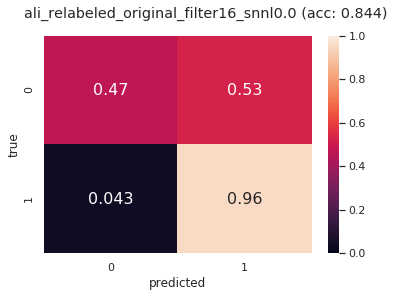

/data/jma/model/binary_cnn_V2/model_experiment_tests/ali_relabeled_undersampled_filter16_snnl0.0/
./data/generated_splits/2class/ali_relabeled_undersampled/eval/
{'0': 0, '1': 1, '2': 2}
pre-processing
in gpu part
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]


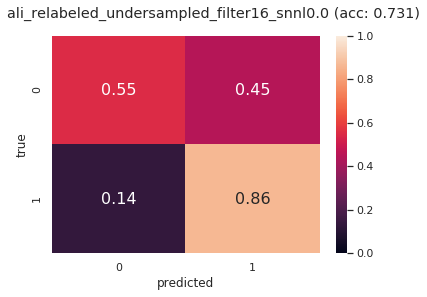

In [56]:
%matplotlib inline

import sklearn

tf.logging.set_verbosity(tf.logging.FATAL)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


tf.summary.FileWriterCache.clear()
b_size = 32


random_seed = 777

convnet_checkpoint_path_base = "/data/jma/model/binary_cnn_V2/model_experiment_tests/"


# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3, 3]]
filter_sizes = [16]
snnl_weights = [0.0]

# data_root = "./data/data_relabeled_png_synthetic/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)



        
dataset_root = "./data/generated_splits/2class/"

# sets = ["ali_relabeled_original", "peter_relabeled_original", "ali_relabeled_undersampled", "peter_relabeled_undersampled"]

sets = ["ali_relabeled_original", "ali_relabeled_undersampled"]


for dt_set in sets:
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:

                
                eval_root = dataset_root + dt_set + "/eval/"
                eval_paths = load_data_util.load_image_paths(eval_root)
                
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, norm=False, shuffle=False)


                
                model_path = convnet_checkpoint_path_base + dt_set + "_filter" + str(filter_size)+"_snnl" + str(snnl_weight) + "/"
                print(model_path)


                model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                            conv_kernels=kernel_size, 
                                                                             num_channels=filter_size,
                                                                            snnl_weight=snnl_weight,
                                                                            log=False)

                model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

               
                values = model.predict(eval_input_fn)


                original_labels = path_to_label(eval_paths, eval_root)
                predictions = list(values)
                
                
                predicted_labels = [elem['class_ids'][0] for elem in predictions]
                
                predicted_probabilities = [elem['probabilities'] for elem in predictions]
                print(predicted_labels)

                
                accuracy = sklearn.metrics.accuracy_score(original_labels, predicted_labels)
                
                cm = tf.confusion_matrix(original_labels, predicted_labels)
                cm = tf.to_float(cm)

                cm = cm.numpy()

                row_sums = cm.sum(axis=1)
                cm = cm / row_sums[:, np.newaxis]

                df_cm = pd.DataFrame(cm, range(2), range(2))
                #plt.figure(figsize = (10,7))
                
                sns.set(font_scale=1)#for label size
                plt.suptitle(dt_set + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight) + " (acc: " + str('%.3f'%(accuracy)) + ")")
                ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, vmin=0, vmax=1.0)# font size
                ax.set(xlabel='predicted', ylabel='true')
                plt.show()

## Incorrectly Classified Images (PNG Format)

/data/jma/model/binary_cnn_V2/model_experiment_tests/ali_relabeled_undersampled_filter8_snnl0.0/
./data/generated_splits/2class/ali_relabeled_undersampled/eval/
{'0': 0, '1': 1, '2': 2}
pre-processing
in gpu part


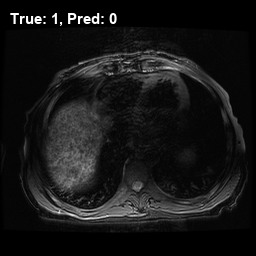

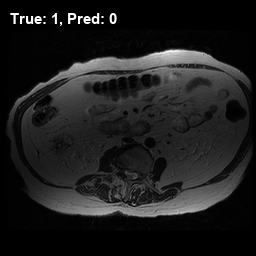

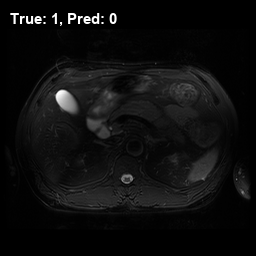

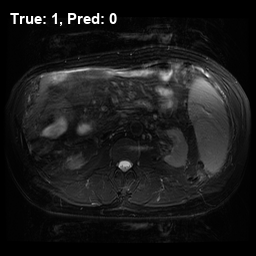

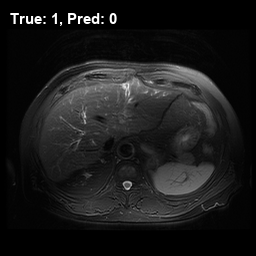

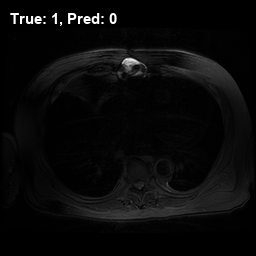

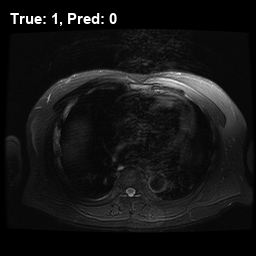

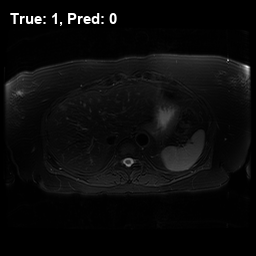

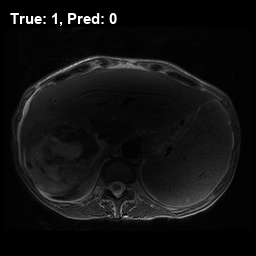

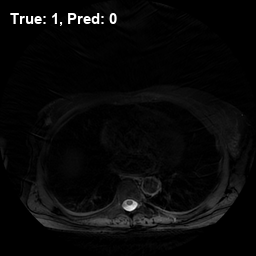

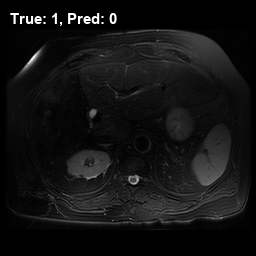

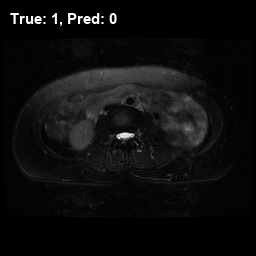

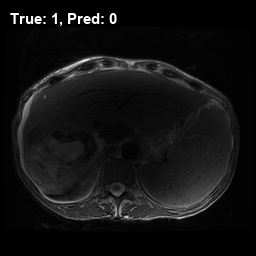

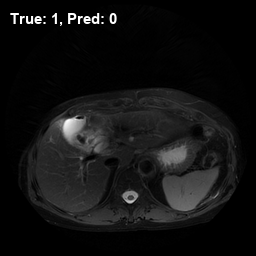

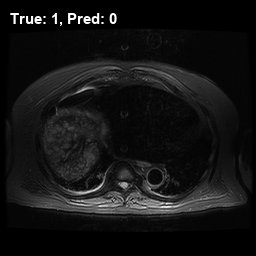

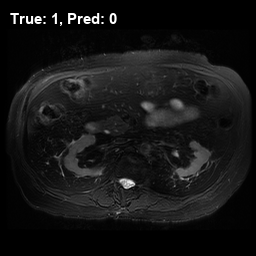

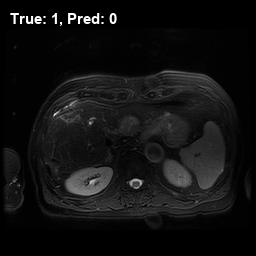

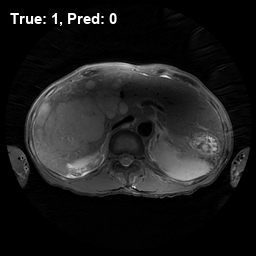

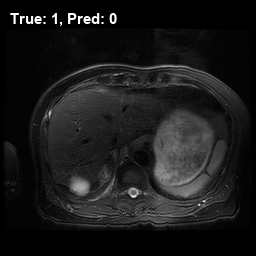

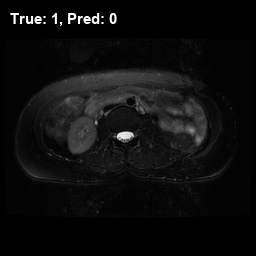

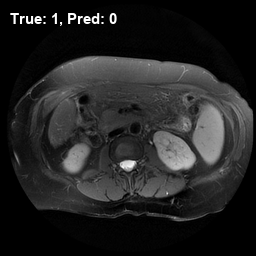

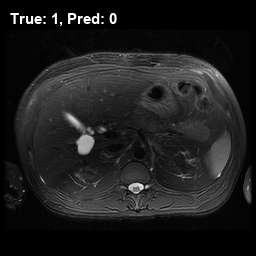

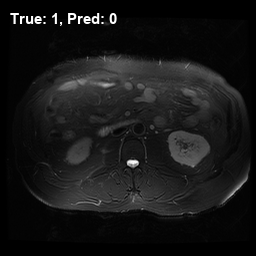

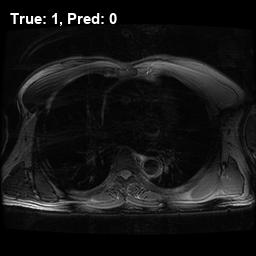

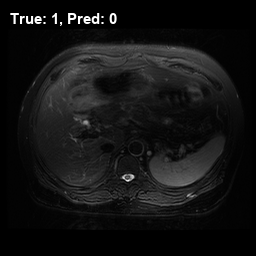

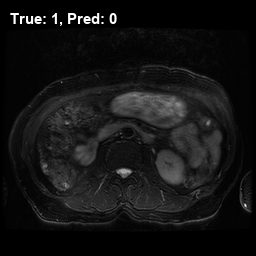

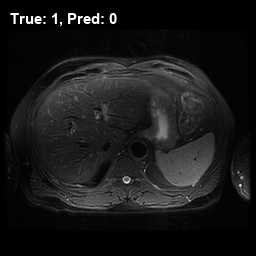

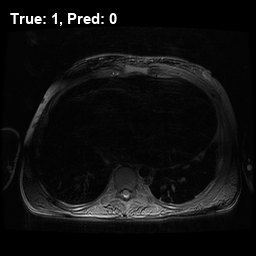

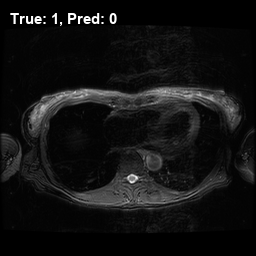

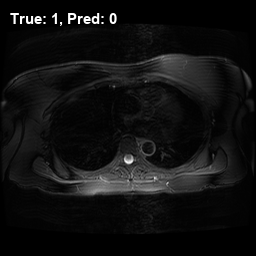

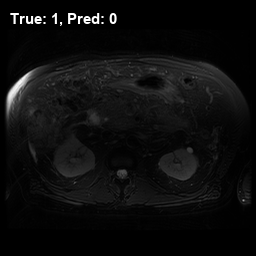

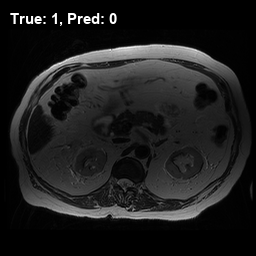

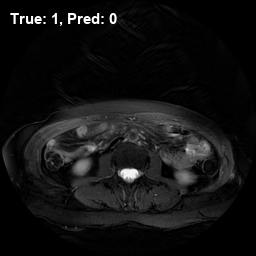

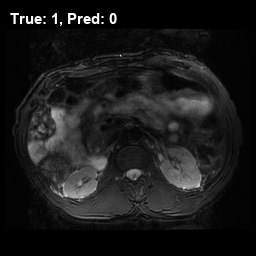

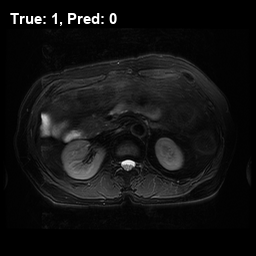

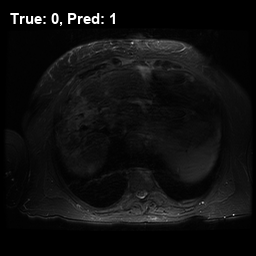

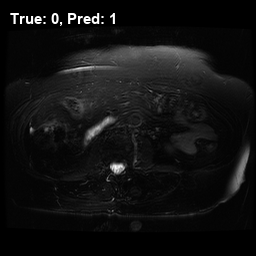

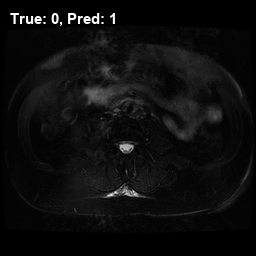

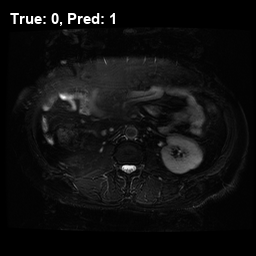

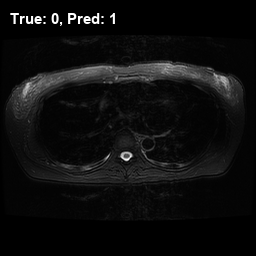

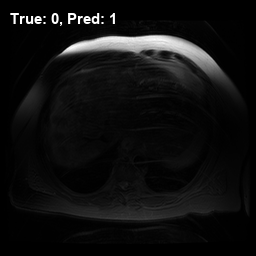

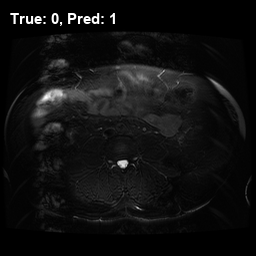

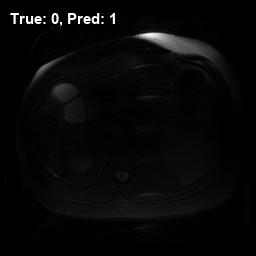

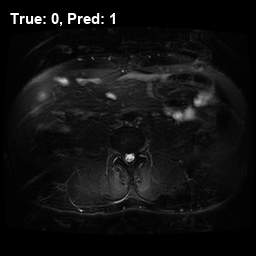

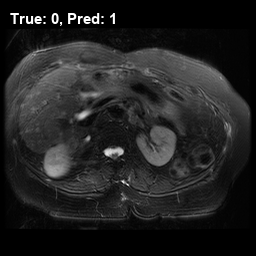

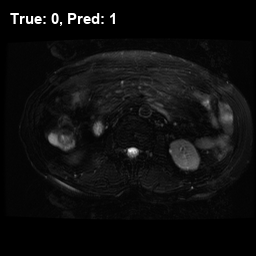

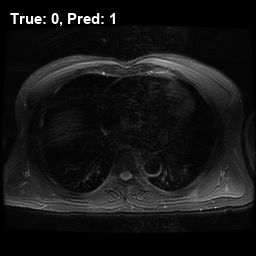

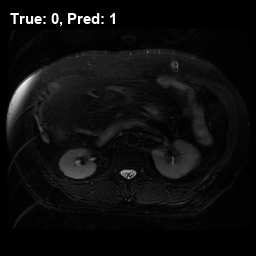

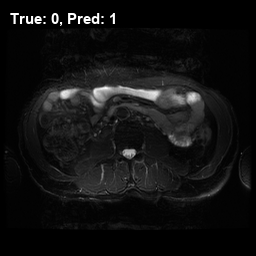

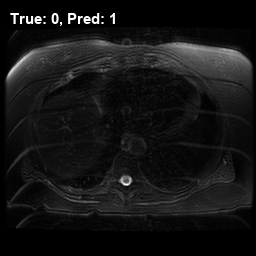

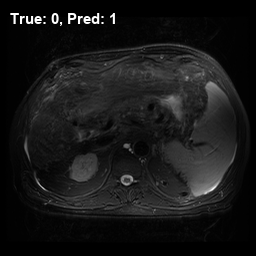

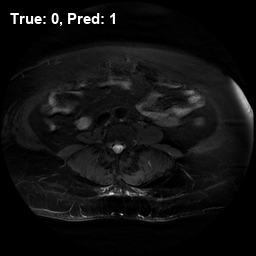

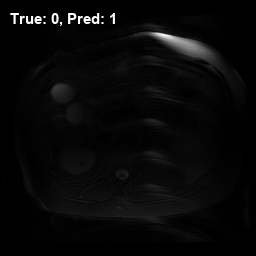

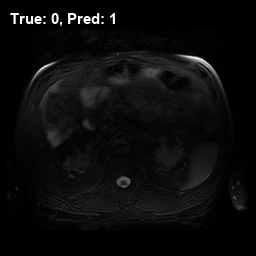

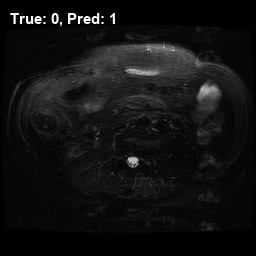

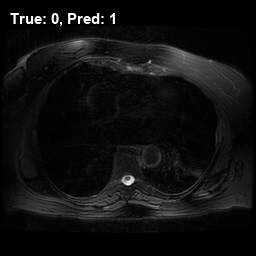

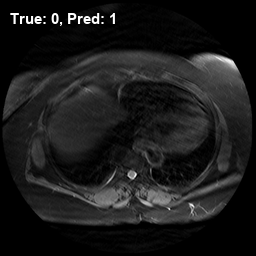

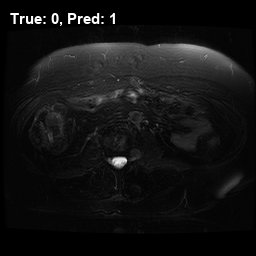

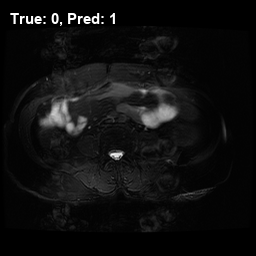

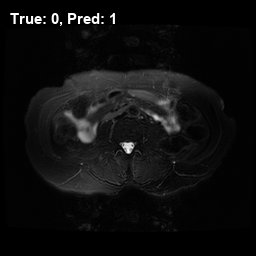

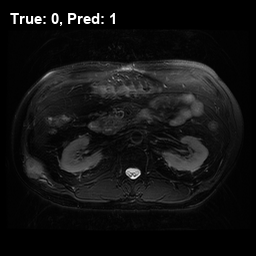

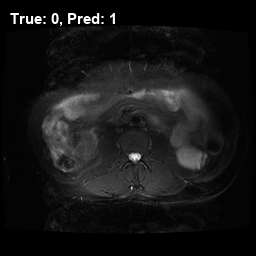

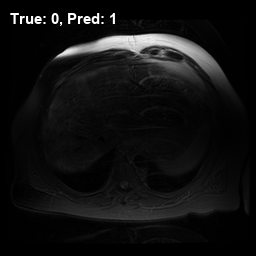

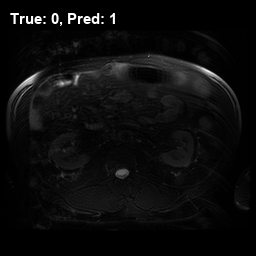

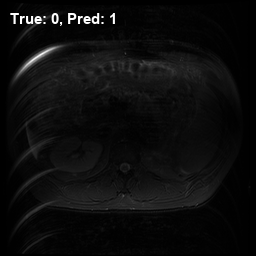

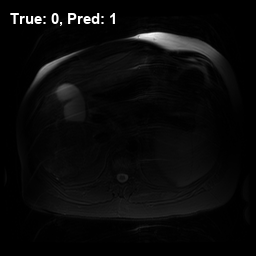

In [86]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

convnet_checkpoint_path_base = "/data/jma/model/binary_cnn_V2/model_experiment_tests/"

dataset_root = "./data/generated_splits/2class/"

eval_root = dataset_root + dt_set + "/eval/"
eval_paths = load_data_util.load_image_paths(eval_root)

eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, norm=False, shuffle=False)


# change these======
working_paths = eval_paths
working_input_fn = eval_input_fn

kernel_size=[10,7,3,3]
filter_size=8
snnl_weight=0.0
#=========

model_path = convnet_checkpoint_path_base + dt_set + "_filter" + str(filter_size)+"_snnl" + str(snnl_weight) + "/"
print(model_path)


model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                            conv_kernels=kernel_size, 
                                                             num_channels=filter_size,
                                                            snnl_weight=snnl_weight,
                                                            log=False)
model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

values = model.predict(eval_input_fn)

original_labels = path_to_label(eval_paths, dataset_root + dt_set + "/eval/")
predicted_labels = list(values)

# make a plot?





for index in range(len(working_paths)):
    if original_labels[index] != predicted_labels[index]["class_ids"][0]:
        # add image to plot

        img = Image.open(working_paths[index])
        
        basewidth = 256

        wpercent = (basewidth/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)

        
        d = ImageDraw.Draw(img)
        
        # debug this shit
        d.text((10,10), "True: " + str(original_labels[index]) + 
               ", Pred: " + str(predicted_labels[index]["class_ids"][0]), 
               fill="white", font=ImageFont.truetype("./fonts/arial-bold.ttf", 15))       
                
        display(img)
    

## ROC Curves

/data/jma/model/binary_cnn_V2/model_experiment_tests/ali_relabeled_original_filter16_snnl0.0/
./data/generated_splits/2class/ali_relabeled_original/eval/
{'0': 0, '1': 1, '2': 2}
pre-processing
in gpu part
[0.         0.46938776 0.46938776 0.48979592 0.48979592 0.53061224
 0.53061224 0.55102041 0.55102041 0.57142857 0.57142857 0.6122449
 0.6122449  0.75510204 0.75510204 0.7755102  0.7755102  0.83673469
 0.83673469 0.93877551 1.        ]
[0.         0.88271605 0.90740741 0.90740741 0.9382716  0.9382716
 0.95679012 0.95679012 0.96296296 0.96296296 0.9691358  0.9691358
 0.97530864 0.97530864 0.98148148 0.98148148 0.98765432 0.98765432
 0.99382716 0.99382716 1.        ]
[2.0000000e+00 1.0000000e+00 9.9999869e-01 9.9998748e-01 9.6220475e-01
 9.1362172e-01 7.3126459e-01 1.8631166e-01 1.5623933e-01 6.8795474e-05
 2.6704722e-05 1.1888364e-06 2.4708189e-07 6.5127868e-12 4.5598325e-12
 1.1704845e-14 1.6240210e-15 2.0073449e-20 3.7363305e-22 7.0584691e-36
 0.0000000e+00]
/data/jma/model/binary_cn

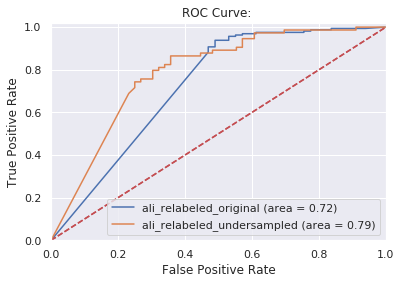

In [78]:
%matplotlib inline

import sklearn

tf.logging.set_verbosity(tf.logging.FATAL)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


tf.summary.FileWriterCache.clear()
b_size = 32


random_seed = 777

convnet_checkpoint_path_base = "/data/jma/model/binary_cnn_V2/model_experiment_tests/"


# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3, 3]]
filter_sizes = [16]
snnl_weights = [0.0]

# data_root = "./data/data_relabeled_png_synthetic/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)



        
dataset_root = "./data/generated_splits/2class/"

# sets = ["ali_relabeled_original", "peter_relabeled_original", "ali_relabeled_undersampled", "peter_relabeled_undersampled"]

sets = ["ali_relabeled_original", "ali_relabeled_undersampled"]


plt.figure()

for dt_set in sets:
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:

                
                eval_root = dataset_root + dt_set + "/eval/"
                eval_paths = load_data_util.load_image_paths(eval_root)
                
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, norm=False, shuffle=False)


                
                model_path = convnet_checkpoint_path_base + dt_set + "_filter" + str(filter_size)+"_snnl" + str(snnl_weight) + "/"
                print(model_path)


                model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                            conv_kernels=kernel_size, 
                                                                             num_channels=filter_size,
                                                                            snnl_weight=snnl_weight,
                                                                            log=False)

                model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

               
                values = model.predict(eval_input_fn)


                original_labels = path_to_label(eval_paths, eval_root)
                predictions = list(values)
                
                predicted_labels = [elem['class_ids'][0] for elem in predictions]
                
                predicted_probabilities = [elem["probabilities"][1] for elem in predictions]
                
        
                
                fpr, tpr, thresholds = sklearn.metrics.roc_curve(original_labels, predicted_probabilities)

                auc = sklearn.metrics.roc_auc_score(original_labels, predicted_probabilities)
                
                print(fpr)
                print(tpr)
                print(thresholds)
                
                
                plt.plot(fpr, tpr, label= dt_set + ' (area = %0.2f)' % auc)
                plt.plot([0, 1], [0, 1], 'r--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.02])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve: ')
                plt.legend(loc="lower right")

plt.show()

                